## Value Function, Decision Rules and Partial Equilibrium

In [8]:
#Infinite Period 
#Import packages
import sympy as sy
import numpy as np
from numpy import *
import math
import matplotlib.pyplot as plt
from scipy import sparse
from scipy.sparse.linalg import spsolve
from itertools import product
from numpy import vectorize
#Using Value Function Iteration for Partial Equilibrium. 

#Declare Parameters
beta = 1/(1+0.06)
r = 0.04         #Interest rate
cbar = 20       #Max level of consumption
period = 100    #Number of periods 
sigma_y = 0.2      #Parameter for income shock
gamma= 0         #Correlation between y and y'

#Define the income shocks
Y = [1-sigma_y, 1+sigma_y]

#Define the minimum and maximum asset level 
a_min= (-Y[0]*(1+r))/r 

#Define the grid for assets
assets= np.array(np.linspace(a_min, 25, period))

#Definte the transition matrix
pi = np.array([[(1+gamma)/2, (1-gamma)/2],[(1-gamma)/2, (1+gamma)/2]])

#Create a grid of assets today, assets tomorrow and income shcoks. 
a_y_grid = list(product(Y,assets,assets))
a_y_grid= np.array(a_y_grid)
y = a_y_grid[:,0]
assets_today=a_y_grid[:,1]
assets_tomorrow=a_y_grid[:,2]

#Define the return matrix that accounts for the utility
@vectorize
def M(y,ai,aj):
    if (y+(1+r)*ai-aj)>0:
        return -0.5*(y+(1+r)*ai-aj-cbar)**2
    else:
        return -1000

#Return Vector
M=M(y, assets_today, assets_tomorrow)
#Return Matrix
M = np.reshape(M,(1,20000))
M=np.reshape(M,(200,100))

#Initial guess for the value function 
Vs=np.zeros(200)

#Define the W matrix for the value function with an initial guess for the value function.
def W1(A):   
    
    return pi[0, 0]*(-0.5*(Y[0] + (1+r)*A - A - cbar)**2)/(1-beta) + pi[0, 1]*(-0.5*(Y[1] + (1+r)*A - A - cbar)**2)/(1-beta)

def W2(A):
    
    return pi[1, 0]*(-0.5*(Y[0] + (1+r)*A - A - cbar)**2)/(1-beta) + pi[1, 1]*(-0.5*(Y[1] + (1+r)*A - A - cbar)**2)/(1-beta)

#Setting up the W matrix for the bad shocks. 
W1=W1(assets)
W1=np.reshape(W1, (100,1))
W1 = np.tile(W1, 100)
W1 = np.transpose(W1)  #We need to transpose the matrix so that we have the transition only from Y[0].  

W2=W2(assets)
W2=np.reshape(W2, (100,1))
W2 = np.tile(W2, 100)
W2 = np.transpose(W2)  #We need to transpose the matrix so that we have the transition only from Y[1].

#Creating the W matrix for the combined shocks
W = [W1, W2]
W= np.reshape(W, (200,100))

#We now need to create the X matrix for the value function to get the new guess
X = M + beta*W
V1 = np.amax(X, axis=1)
Diff_V = abs(V1-Vs)
epsilon = 0.01
count = 0 


465


Text(0.5,1,'Consumption policy function')

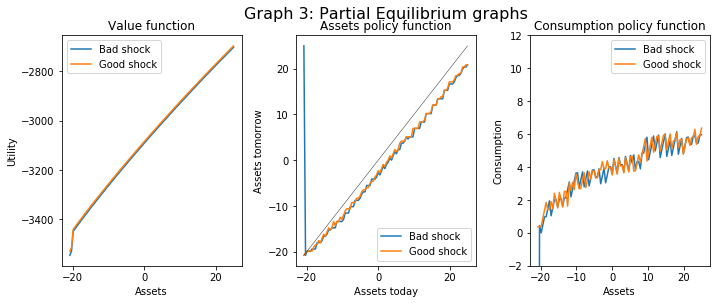

In [9]:
#Running the whole While Loop

while Diff_V.all()>epsilon:
    Vs_guess = V1 
    V_guess = [Vs_guess[0:100], Vs_guess[100:]] #reshape the vector into two columns, one for each shock. 
    V_guess = np.array(V_guess)

    def W1(V_guess):
        
        return pi[0, 0]*V_guess[0, :] + pi[0, 1]*V_guess[1, :]
    
    def W2(V_guess):
        
        return pi[1, 0]*V_guess[0, :] + pi[1, 1]*V_guess[1, :]
    
    W1=W1(V_guess)
    W1=np.reshape(W1, (1,100))
    W1 = np.tile(W1, 100)
    W1 = np.transpose(W1)  #We need to transpose the matrix so that we have the transition only from Y[0].  

    W2=W2(V_guess)
    W2=np.reshape(W2, (1,100))
    W2 = np.tile(W2, 100)
    W2 = np.transpose(W2)  #We need to transpose the matrix so that we have the transition only from Y[1].

    #Creating the W matrix for the combined shocks
    W = [W1, W2]
    W= np.reshape(W, (200,100))
    
    X = M + beta*W
    
    V1 = np.amax(X, axis = 1)
    
    Diff_V = abs(Vs_guess-V1)
    
    count += 1

print(count)
#Now, for the policy functions we require the Χ matrix. 
#X = M + beta*W

#8.1. Value function
V_bad = V1[0:100]
V_good = V1[100:]

#8.2. Policy function
X = M + beta*W

#8.2.2. Assets policies
g = np.argmax(X, axis = 1)
a_bad = assets[g[0:100]]     
a_good = assets[g[100:]]

#8.2.3. Consumption policies
c_bad = Y[0]*np.ones(100) + (1+r)*assets - a_bad

c_good = Y[1]*np.ones(100) + (1+r)*assets - a_good

#PLOT EVERYTHING
plt.figure
plt.suptitle("Graph 3: Partial Equilibrium graphs", x=0.75, y=1, fontsize=16)
plt.subplots_adjust(top=0.9, bottom=0.1, left=0, right=1.5, hspace=0.3, wspace=0.3)

plt.subplot(131)
plt.plot(assets,V_bad, label='Bad shock')
plt.plot(assets,V_good, label='Good shock')
plt.xlabel('Assets')
plt.ylabel('Utility')
#plt.ylim([-25000, -19000])
plt.legend()
plt.title('Value function')

plt.subplot(132)
plt.plot(assets,a_bad, label='Bad shock')
plt.plot(assets,a_good, label='Good shock')
plt.plot(assets,assets, 'k', linewidth=0.4)
plt.xlabel('Assets today')
plt.ylabel('Assets tomorrow')
#plt.ylim([-23, -6])
plt.legend()
plt.title('Assets policy function')

plt.subplot(133)
plt.plot(assets,c_bad, label='Bad shock')
plt.plot(assets,c_good, label='Good shock')
plt.xlabel('Assets')
plt.ylabel('Consumption')
plt.ylim([-2, 12])
plt.legend()
plt.title('Consumption policy function')

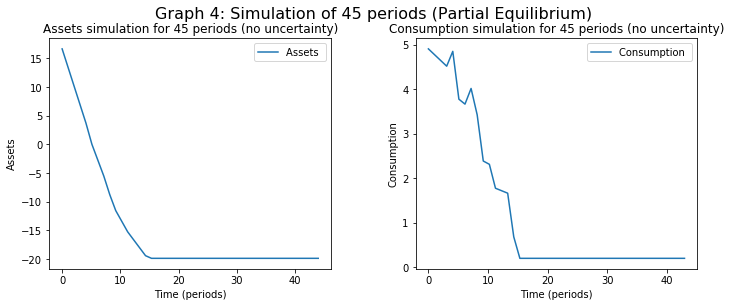

In [18]:
#Simulation of 45 periods of the economy

#%% 
#Simulate the shocks of an economy for T=45
y=np.zeros([1,100])
for i in range(0,100):
    y[0,i]=1  #in all cases, since gamma=0, our income is going to be 1

#Simulation of assets
        
simulation=np.zeros(45)

aopt_y1 = assets[g[0:100]]     # optimal decision of assets 

g_y1=g[0:100]

simulation[0]=g_y1[99] #our initial guess of assets  (a0)

for i in range(1,45):
        simulation[i]=g_y1[int(simulation[i-1])]
        
for i in range(0,44):
        simulation[i]=aopt_y1[int(simulation[i])]


        
#Plot simulation assets with NO uncertainty
t=np.linspace(0,44,44)

w=1
#Simulation and plot of consumption with NO uncertainty
c=np.zeros(44)
for i in range(0,44):
    c[i]=simulation[i]*(1+r)+w*y[0,i]-simulation[i+1]
    if c[i]<=0:
        c[i]=0

plt.figure()
plt.suptitle("Graph 4: Simulation of 45 periods (Partial Equilibrium)", x=0.75, y=1.01, fontsize=16)
plt.subplots_adjust(top=0.9, bottom=0.1, left=0, right=1.5, hspace=0.3, wspace=0.3)

plt.subplot(121)
plt.plot(t,simulation[0:44], label = 'Assets ')
plt.title('Assets simulation for 45 periods (no uncertainty)')
plt.legend()
plt.ylabel('Assets')
plt.xlabel('Time (periods)')

        
plt.subplot(122)
plt.plot(t[0:43],c[0:43], label = 'Consumption ')
plt.title('Consumption simulation for 45 periods (no uncertainty)')
plt.legend()
plt.ylabel('Consumption')
plt.xlabel('Time (periods)')
plt.show()
